## Load meta data

In [1]:
from pandas import read_csv
from ast import literal_eval

csv_path = 'meta_with_nf.csv'
df = read_csv(csv_path)
df['pos_s'] = df['pos_s'].apply(literal_eval)
df['spacing'] = df['spacing'].apply(literal_eval)

## Load example data

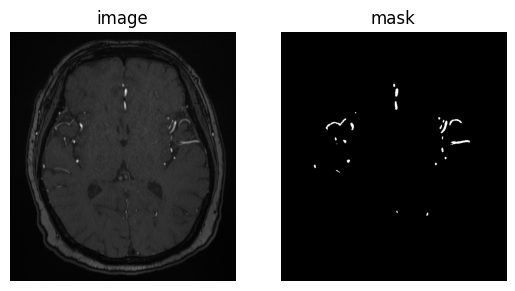

In [25]:
import matplotlib.pyplot as plt
from medpy.io.load import load

idx = 1
img, _ = load(df['data_path'][idx])
mask, _ = load(df['mask_path'][idx])

mid_slice = img.shape[-1] // 2
plt.figure()
plt.subplot(121)
plt.imshow(img[:, :,mid_slice].transpose(1,0), cmap='gray')
plt.axis('off')
plt.title('image')
plt.subplot(122)
plt.imshow(mask[:, :,mid_slice].transpose(1,0), cmap='gray')
plt.axis('off')
plt.title('mask')
plt.show()

## Compute scores of simple threshold segmentation

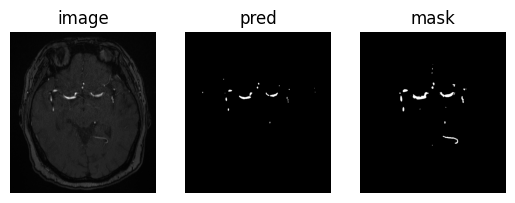

In [28]:
import numpy as np
from medpy.metric.binary import assd

def DSC(pred_img, label_img):
    A = label_img > 0.5 * np.max(label_img)
    B = pred_img > 0.5 * np.max(pred_img)
    return 2*np.sum(A[A==B])/(np.sum(A)+np.sum(B))

# position of stenosis
pos_s = df['pos_s'][idx]

# normalization factors for AHD score
# computed by the function in the final cell
nc = df['nf_ahd'][idx]
nc_s = df['nf_ahd_s'][idx]
spacing = df['spacing'][idx]

th = 0.3
pred_img = img > img.max() * th

# pos_s = -1 for some cases without stenosis
if pos_s != -1:
    stenosis_slice = (pos_s[-2] + pos_s[-1]) // 2
else:
    stenosis_slice = img.shape[-1] // 2
    
plt.figure()
plt.subplot(131)
plt.imshow(img[:, :, stenosis_slice].transpose(1,0), cmap='gray')
plt.axis('off')
plt.title('image')
plt.subplot(132)
plt.imshow(pred_img[:, :, stenosis_slice].transpose(1,0), cmap='gray')
plt.axis('off')
plt.title('pred')
plt.subplot(133)
plt.imshow(mask[:, :, stenosis_slice].transpose(1,0), cmap='gray')
plt.axis('off')
plt.title('mask')
plt.show()

In [29]:
dsc_score = DSC(pred_img, mask)
ahd = assd(pred_img, mask, voxelspacing=spacing)
ahd_score = max((nc - ahd) / nc, 0)

# for DSC_stenosis and AHD_stenosis
if pos_s != -1:
    mask_s = mask[pos_s[0]:pos_s[1], pos_s[2]:pos_s[3], pos_s[4]:pos_s[5]]
    pred_img_s = pred_img[pos_s[0]:pos_s[1], pos_s[2]:pos_s[3], pos_s[4]:pos_s[5]]
    dsc_score_s = DSC(pred_img_s, mask_s)
    
    if pred_img_s.sum() > 0:
        ahd_s = assd(pred_img_s, mask_s, voxelspacing=spacing)
    else:
        ahd_s = nc_s
    
    ahd_score_s = max((nc_s - ahd_s) / nc_s, 0)
    finial_score = 0.35 * dsc_score + 0.35 * (ahd_score) + 0.15 * dsc_score_s + 0.15 * ahd_score_s
    
else:
    finial_score = 0.5 * dsc_score + 0.5 * (ahd_score)

sd = {
    'DSC': dsc_score,
    'DSC_stenosis': dsc_score_s,
    'AHD': ahd_score,
    'AHD_stenosis': ahd_score_s,
    'Finial_score': finial_score,
}

for key in sd.keys():
    print(f"{key} : {sd[key]:.2f}")

DSC : 0.58
DSC_stenosis : 0.60
AHD : 0.37
AHD_stenosis : 0.31
Finial_score : 0.47


In [24]:
def compute_norm_factor(img, mask, spacing, pos_s):
    # compute the norm facter of AHD scores
    # , using AHD scores of segmentation by simple threshold
    ahd = []
    ahd_s = []
    for th in [0.2, 0.3, 0.4]:
        pred_img = img > img.max() * th
        ahd.append(assd(pred_img, mask, voxelspacing=spacing))

    if pos_s != -1:
        mask_s = mask[pos_s[0]:pos_s[1], pos_s[2]:pos_s[3], pos_s[4]:pos_s[5]]
        pred_img_s = pred_img[pos_s[0]:pos_s[1], pos_s[2]:pos_s[3], pos_s[4]:pos_s[5]]
        if pred_img_s.max() == False:
            pred_img_s[int(pred_img_s.shape[0]/2), int(pred_img_s.shape[1]/2), int(pred_img_s.shape[2]/2)] = 1
        ahd_s.append(assd(pred_img_s, mask_s, voxelspacing=spacing))
    else:
        ahd_s.append(-1)

    nf = np.mean(ahd)
    nf_s = np.mean(ahd_s) if ahd_s[0] != -1 else -1
    return nf, nf_s